In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

#opening data
import os
import pathlib
import warnings

#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [3]:
df = pd.DataFrame()
file_name = 'events_England.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.concat([df, pd.DataFrame(data)])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


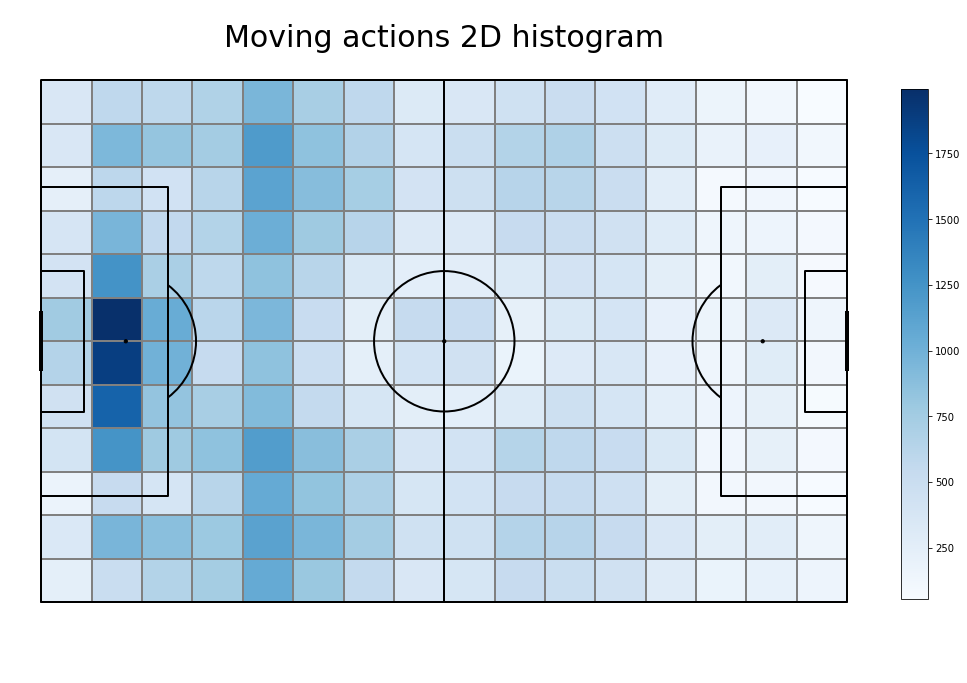

In [40]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["nextPlayerId"] = next_event["playerId"]
df["nextTeamId"] = next_event["teamId"]

df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
# move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
move_df = df.loc[df['subEventName'].isin(['Ground defending duel', 'Ground loose ball duel', 'Launch', 'Clearance'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

# filter out actions for the middle 3rd only
# move_df = move_df.loc[(move_df["x"] < 2*105/3) & (move_df["x"] > 105/3)]

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

In [41]:
df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,nextPlayerId,nextTeamId,kickedOut
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,370224,1609,0
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,3319,1609,0
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,120339,1609,0


In [42]:
move_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,nextPlayerId,nextTeamId,kickedOut,x,y,end_x,end_y
22,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",2499719,Duel,1631,1H,38.191874,13,177959205,Ground loose ball duel,0,1609,0,70.35,53.04,74.55,57.80
23,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",0,"[{'y': 78, 'x': 33}, {'y': 85, 'x': 29}]",2499719,Duel,1609,1H,38.191874,13,177961219,Smart pass,14763,1631,0,34.65,14.96,30.45,10.20
26,8,Launch,[{'id': 1801}],7882,"[{'y': 53, 'x': 4}, {'y': 44, 'x': 40}]",2499719,Pass,1609,1H,44.425679,84,177959187,Air duel,192748,1631,0,4.20,31.96,42.00,38.08
29,1,Ground defending duel,"[{'id': 504}, {'id': 701}, {'id': 1802}]",149019,"[{'y': 49, 'x': 56}, {'y': 54, 'x': 45}]",2499719,Duel,1631,1H,49.182566,12,177959213,Ground attacking duel,7945,1609,0,58.80,34.68,47.25,31.28
32,1,Ground defending duel,"[{'id': 502}, {'id': 701}, {'id': 1802}]",192748,"[{'y': 54, 'x': 45}, {'y': 56, 'x': 36}]",2499719,Duel,1631,1H,52.009543,12,177959215,Ground defending duel,8488,1631,0,47.25,31.28,37.80,29.92


In [43]:
move_count

array([[ 353.,  581.,  588.,  673.,  952.,  724.,  585.,  321.,  355.,
         451.,  507.,  435.,  278.,  167.,  123.,   57.],
       [ 354.,  942.,  827.,  747., 1191.,  859.,  666.,  395.,  497.,
         659.,  681.,  487.,  316.,  198.,  218.,  125.],
       [ 234.,  595.,  428.,  632., 1120.,  895.,  735.,  420.,  466.,
         636.,  627.,  505.,  274.,   91.,  126.,   72.],
       [ 385.,  962.,  566.,  657., 1022.,  776.,  634.,  324.,  326.,
         538.,  509.,  447.,  300.,  142.,  162.,   98.],
       [ 420., 1255.,  715.,  594.,  852.,  629.,  352.,  250.,  263.,
         319.,  419.,  393.,  257.,  119.,  258.,   80.],
       [ 767., 1994., 1046.,  614.,  945.,  520.,  255.,  546.,  525.,
         224.,  345.,  402.,  220.,  164.,  325.,  141.],
       [ 649., 1882., 1000.,  546.,  858.,  490.,  240.,  422.,  450.,
         185.,  310.,  362.,  222.,  144.,  288.,  111.],
       [ 446., 1609.,  834.,  729.,  914.,  555.,  375.,  255.,  250.,
         315.,  468.,  395

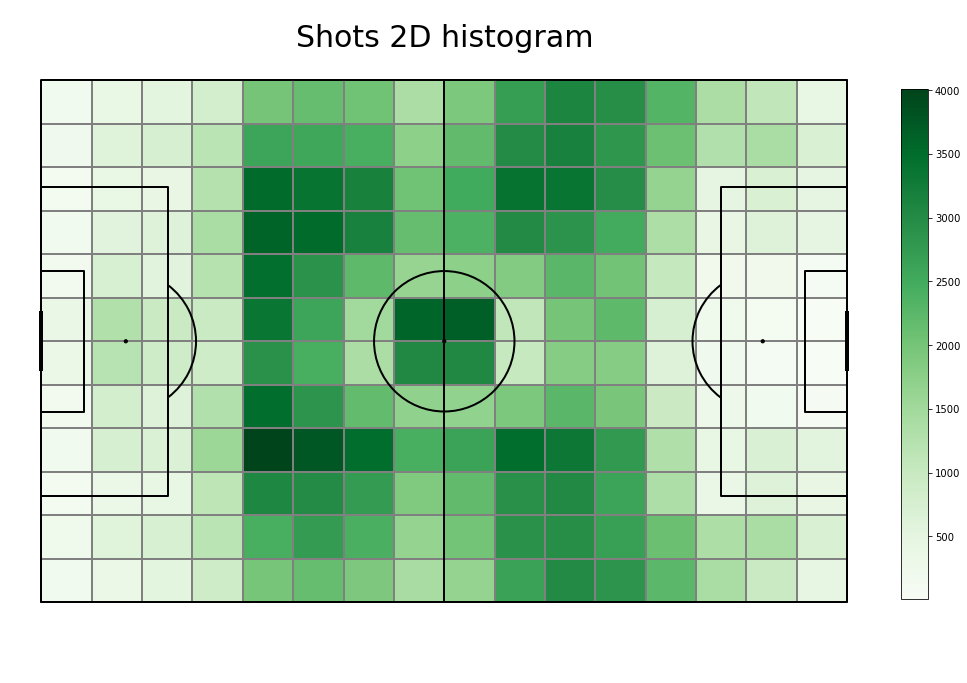

In [44]:
#get shot df
# shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

In [45]:
shot_count

array([[ 169.,  416.,  535.,  819., 2010., 2150., 2051., 1371., 1921.,
        2704., 3109., 2960., 2335., 1384., 1094.,  425.],
       [ 213.,  613.,  765., 1176., 2598., 2568., 2440., 1736., 2185.,
        3002., 3175., 2832., 2093., 1290., 1398.,  723.],
       [ 130.,  391.,  447., 1267., 3534., 3397., 3161., 2045., 2517.,
        3404., 3375., 2972., 1650.,  483.,  715.,  502.],
       [ 177.,  588.,  630., 1391., 3612., 3526., 3170., 2137., 2397.,
        3022., 2874., 2496., 1368.,  444.,  650.,  495.],
       [ 162.,  731.,  587., 1237., 3473., 2898., 2220., 1623., 1734.,
        1848., 2262., 2036., 1041.,  228.,  230.,  100.],
       [ 384., 1307.,  977.,  979., 3355., 2595., 1500., 3603., 3679.,
        1115., 2008., 2223.,  772.,  242.,  108.,   18.],
       [ 361., 1224.,  890.,  912., 2906., 2435., 1381., 3045., 3055.,
        1025., 1815., 1817.,  638.,  204.,   95.,   12.],
       [ 142.,  820.,  624., 1292., 3480., 2865., 2177., 1701., 1682.,
        1929., 2271., 1953

In [46]:
shot_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,nextPlayerId,nextTeamId,kickedOut,x,y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,370224,1609,0,51.45,34.68
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,3319,1609,0,32.55,14.96
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,120339,1609,0,53.55,17.00
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,167145,1609,0,36.75,19.72
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,3319,1609,0,43.05,3.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643134,8,Simple pass,[{'id': 1801}],8313,"[{'y': 63, 'x': 65}, {'y': 96, 'x': 61}]",2500098,Pass,1633,2H,2760.286946,85,251596219,Simple pass,379209,1633,0,68.25,25.16
643135,8,Simple pass,[{'id': 1801}],379209,"[{'y': 96, 'x': 61}, {'y': 85, 'x': 40}]",2500098,Pass,1633,2H,2763.698599,85,251596221,Touch,8561,1633,0,64.05,2.72
643141,8,Simple pass,[{'id': 1801}],8561,"[{'y': 70, 'x': 59}, {'y': 89, 'x': 53}]",2500098,Pass,1633,2H,2783.137836,85,251596225,High pass,20620,1633,0,61.95,20.40
643142,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,2785.702032,83,251596226,Cross,14703,1633,0,55.65,7.48


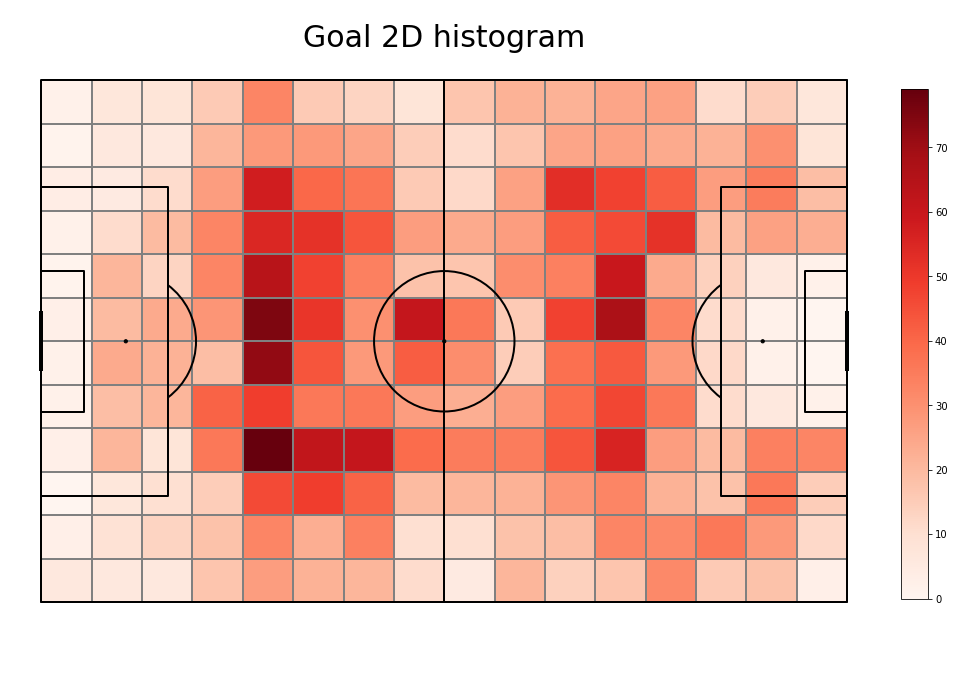

In [47]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':1901} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

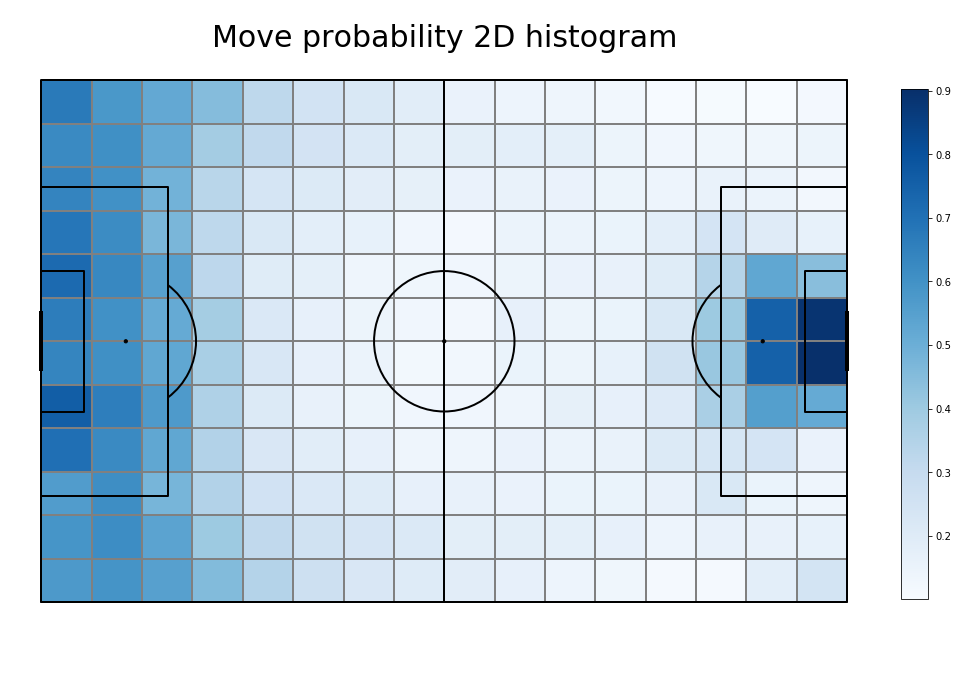

In [48]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

In [49]:
len(move_probability)

12

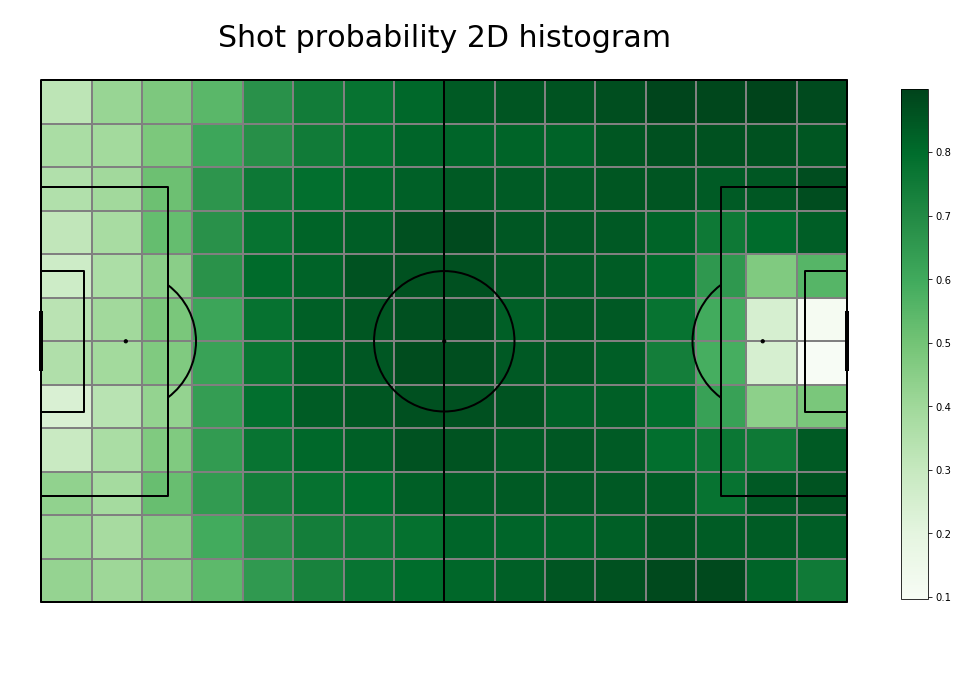

In [50]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

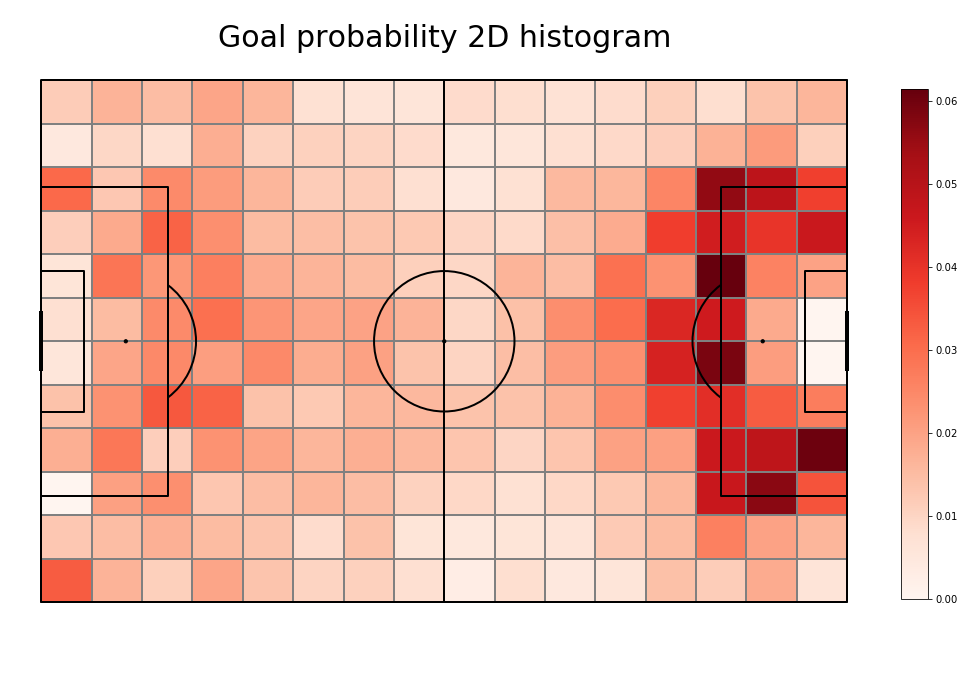

In [51]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

In [52]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

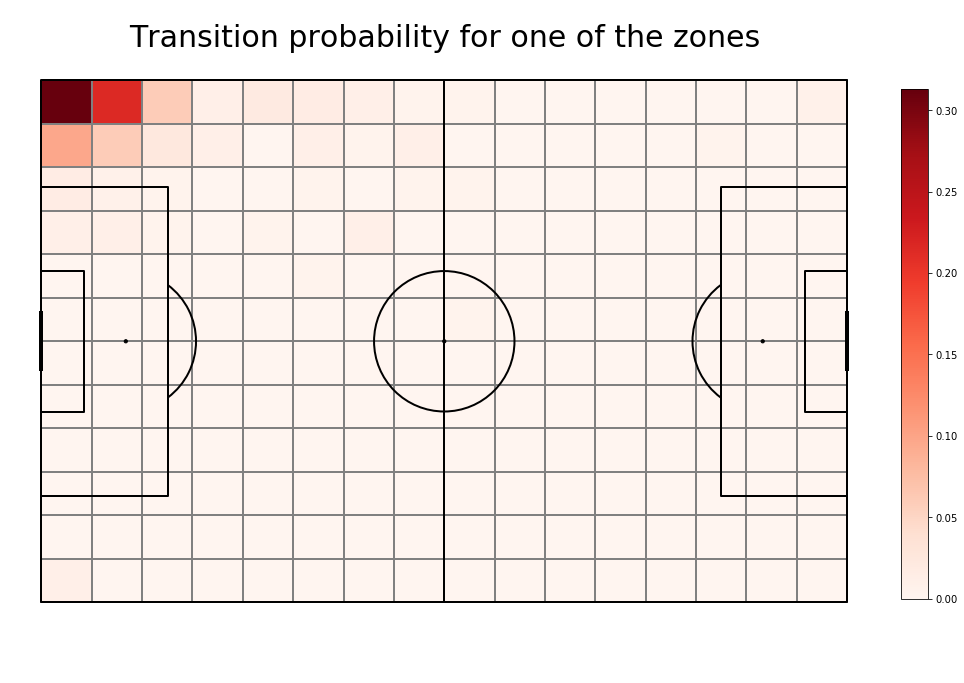

In [53]:
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[0]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the zones', fontsize = 30)
plt.show()

In [54]:
move_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,nextEvent,nextPlayerId,nextTeamId,kickedOut,x,y,end_x,end_y,start_sector,end_sector
22,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",2499719,Duel,1631,1H,38.191874,...,Ground loose ball duel,0,1609,0,70.35,53.04,74.55,57.80,"(11, 10)","(12, 11)"
23,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",0,"[{'y': 78, 'x': 33}, {'y': 85, 'x': 29}]",2499719,Duel,1609,1H,38.191874,...,Smart pass,14763,1631,0,34.65,14.96,30.45,10.20,"(6, 3)","(5, 2)"
26,8,Launch,[{'id': 1801}],7882,"[{'y': 53, 'x': 4}, {'y': 44, 'x': 40}]",2499719,Pass,1609,1H,44.425679,...,Air duel,192748,1631,0,4.20,31.96,42.00,38.08,"(1, 6)","(7, 7)"


In [55]:
df_count_starts.head(3)

,start_sector,count_starts
0,"(1, 1)",246
1,"(1, 2)",337
2,"(1, 3)",178


In [56]:
df_count_starts.iloc[0]

start_sector    (1, 1)
count_starts       246
Name: 0, dtype: object

In [57]:
transition_matrices[0]

array([[0.31300813, 0.21544715, 0.06097561, 0.01219512, 0.0203252 ,
        0.01626016, 0.01219512, 0.00406504, 0.00406504, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00813008],
       [0.09756098, 0.06097561, 0.02439024, 0.01219512, 0.        ,
        0.01219512, 0.00406504, 0.01219512, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00406504, 0.        ,
        0.        ],
       [0.01626016, 0.00813008, 0.00406504, 0.        , 0.        ,
        0.00406504, 0.        , 0.00406504, 0.00406504, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.01219512, 0.01219512, 0.00406504, 0.        , 0.00406504,
        0.        , 0.01219512, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00406504, 0.        , 

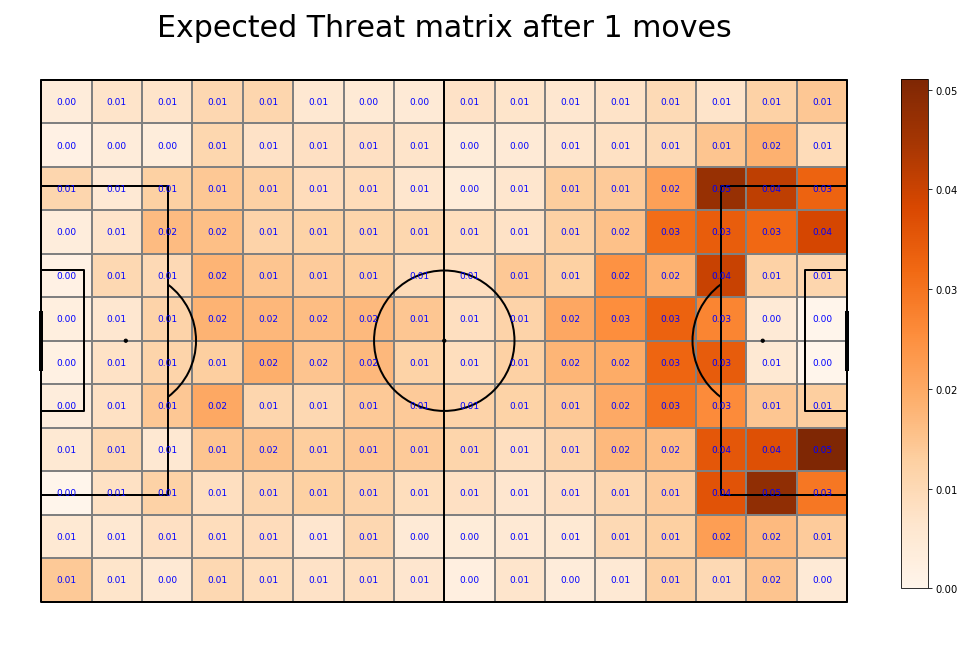

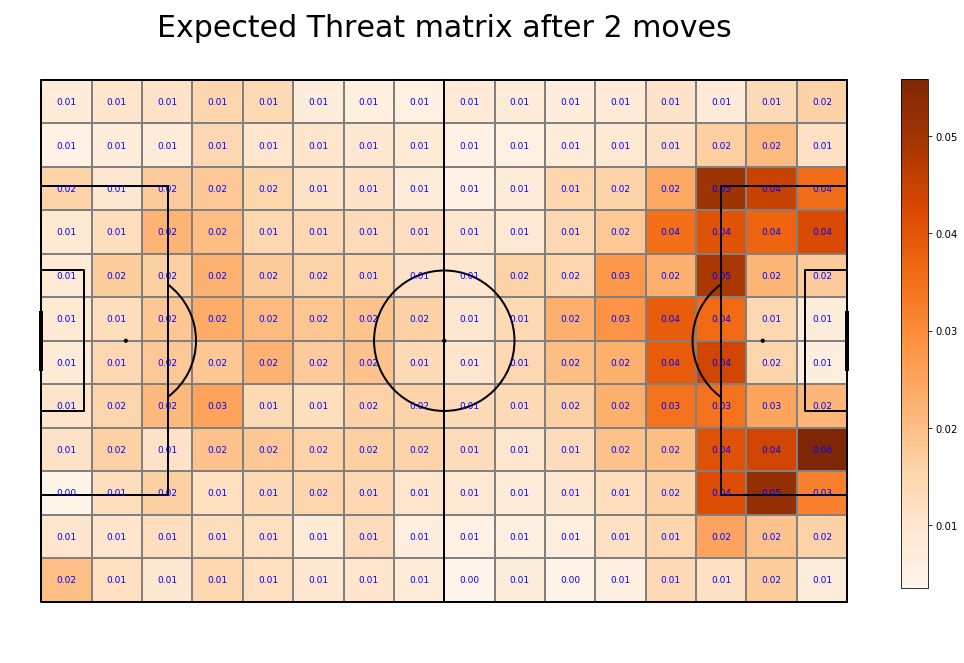

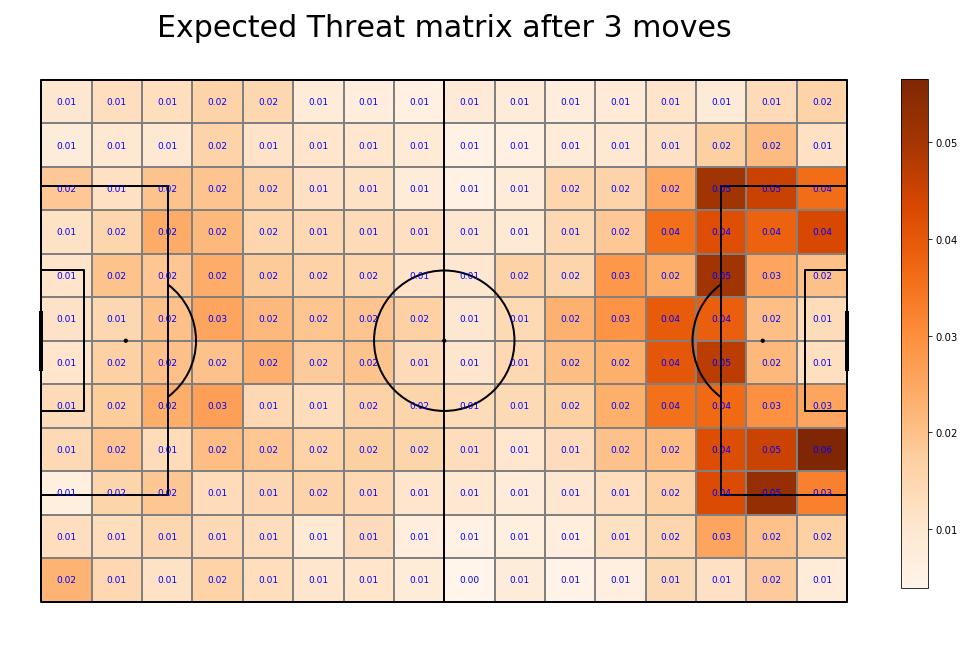

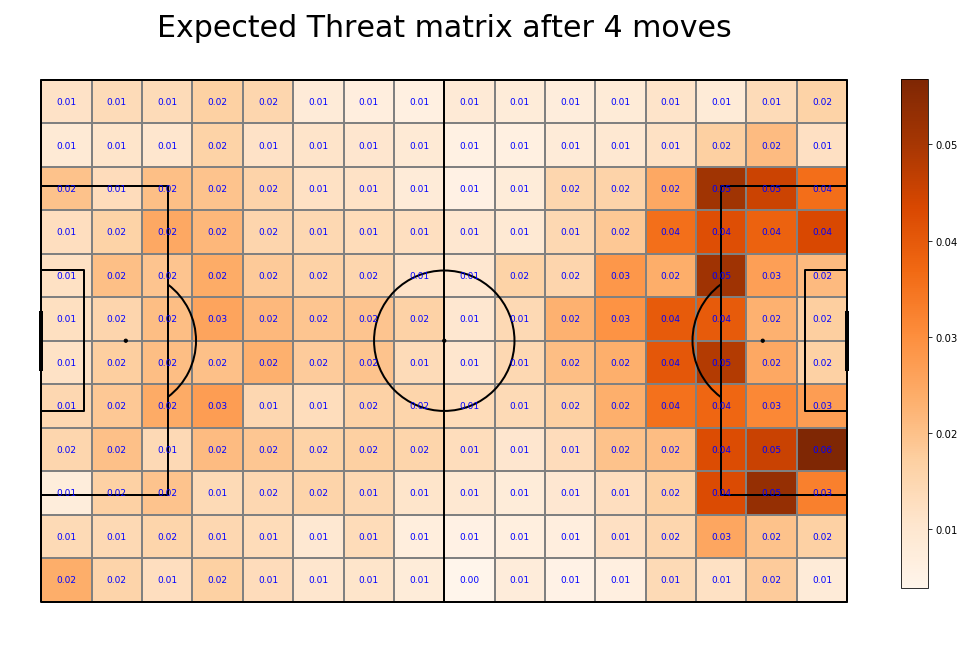

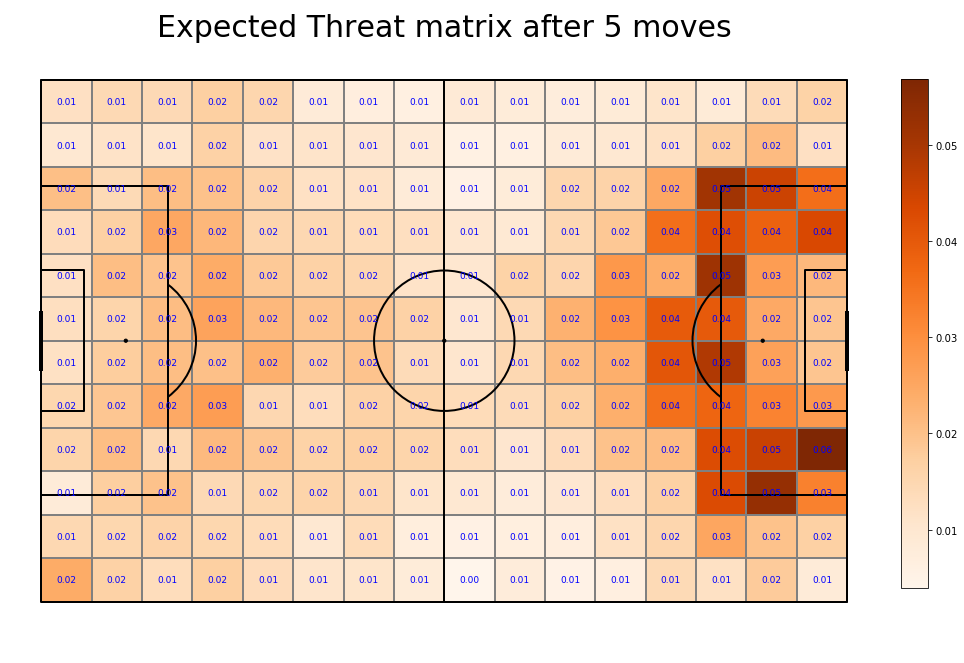

In [59]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12,16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [60]:
xT

array([[0.01225367, 0.01445795, 0.01436854, 0.01725822, 0.01547267,
        0.00836694, 0.00693777, 0.00632241, 0.00881426, 0.0081806 ,
        0.00731965, 0.00863581, 0.01114413, 0.00847381, 0.01384082,
        0.01650402],
       [0.00965982, 0.01155554, 0.01102741, 0.01663197, 0.01172284,
        0.01122432, 0.0103518 , 0.00886804, 0.00578649, 0.00626977,
        0.00829639, 0.00966001, 0.01201163, 0.01726783, 0.02110034,
        0.01222533],
       [0.02046838, 0.01404235, 0.02078801, 0.01987316, 0.01625854,
        0.0121307 , 0.01177036, 0.00831791, 0.00556189, 0.0081598 ,
        0.01532877, 0.0162191 , 0.0248048 , 0.05105999, 0.04543355,
        0.03615321],
       [0.01347231, 0.01676493, 0.0251508 , 0.02211041, 0.01556224,
        0.0148483 , 0.01382276, 0.01265269, 0.01023842, 0.00942229,
        0.01476315, 0.01869951, 0.03580752, 0.04235807, 0.03841216,
        0.04360494],
       [0.01235364, 0.0207126 , 0.01970471, 0.02435801, 0.01839327,
        0.01667085, 0.01530071, 

In [ ]:
#only successful
successful_moves = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

#calculatexT
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

#only progressive
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

In [55]:
# intercepted middle 3rd passes
interceptions = move_df.loc[move_df.apply(lambda x:{'id':1802} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

# calculate potential xT
interceptions["xT_saved"] = interceptions.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1], axis = 1)

# only if possession changes
value_saving_actions = interceptions.loc[interceptions["teamId"] != interceptions["nextteamId"]]

In [ ]:
value_adding_actions

In [ ]:
# Don’t remove unsuccessful and non-progressive actions. Assign -xT for unsuccessful ones!

#calculatexT
move_df["xT_added"] = move_df.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

move_df.head(3)

In [67]:
#group by player
xT_added_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

#merging player name
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]
summary = xT_added_by_player.merge(to_merge, how = "left", on = ["playerId"])

#filtering over 400 per game
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'minutes_played_per_game_England.json')
minutes_per_game = pd.read_json(path, encoding='unicode-escape')
minutes_per_game.rename(columns = {'playerId':'playerId'}, inplace=True)
# with open(path) as f:
#     minutes_per_game = json.load(f)
# minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

#calculating per 90
summary["xT_added_per_90"] = summary["xT_added"]*90/summary["minutesPlayed"]

In [68]:
summary.head()

,playerId,minutesPlayed,xT_added,shortName,role,xT_added_per_90
0,36,1238,0.073226,T. Alderweireld,Defender,0.005323
2,48,3343,0.409651,J. Vertonghen,Defender,0.011029
3,54,3348,0.255259,C. Eriksen,Midfielder,0.006862
5,74,1514,0.120746,R. Klavan,Defender,0.007178
6,93,2942,0.245448,J. Guðmunds­son,Midfielder,0.007509


In [69]:
player_df.head(3)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,playerId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,Goalkeeper,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,Defender,"{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,Goalkeeper,"{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null


In [70]:
minutes_per_game.head(3)

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,9206,C. Wood,2500089,1646,Burnley FC,0,61,61,0
1,9127,S. Vokes,2500089,1646,Burnley FC,61,95,34,0
2,93,J. Guðmunds­son,2500089,1646,Burnley FC,0,80,80,0


In [28]:
possession_dict = {}

#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = df.loc[df["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] = (match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] 
                                                                + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1])
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"]\
                                    .isin(["Air duel", "Ground defending duel","Ground loose ball duel"])]\
                                        .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possession_dict[str(player_id)]["team_passes"] += len(team_passes)
    possession_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possession for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}

#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possession"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)

In [29]:
percentage_df.head(3)

,playerId,possession
0,9206,0.446999
1,9127,0.439018
2,93,0.438288


In [30]:
# save the percentage_df containing player possessions for future use
percentage_df.to_json('../data/Wyscout/minutes_played/player_possession_England.json')

In [56]:
#adjusting for possession
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'player_possession_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)

#merge it
# percentage_df.rename(columns = {'playerId':'nextplayerId'}, inplace=True)
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
summary["xT_added_adjusted_per_90"] = (summary["xT_added"]/summary["possession"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_added_adjusted_per_90']].sort_values(by='xT_added_adjusted_per_90', ascending=False).head(25)

,shortName,xT_added_adjusted_per_90
370,N. Vlašić,0.044305
205,N. Pope,0.043582
268,C. Tosun,0.039367
236,M. Darmian,0.037870
353,L. Mousset,0.037833
155,H. Robson-Kanu,0.036620
142,J. McClean,0.036306
196,K. Long,0.036065
128,G. Murray,0.035896
270,C. Mbemba,0.035385
